In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import xpress  as xp

Using the Community license in this session. If you have a full Xpress license, first set the XPAUTH_PATH environment variable to the full path to your license file, xpauth.xpr, and then restart Python. If you want to use the FICO Community license and no longer want to see this message, set the XPAUTH_PATH environment variable to: /home/alex/.local/lib/python3.9/site-packages/xpress/license/community-xpauth.xpr
NB: setting XPAUTH_PATH will also affect any other Xpress products installed on your system.


In [46]:
# input
N = 7
L = 1

custom_setup = True
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [47]:
# Customers’ demand and preferences
q = np.ones(N)
C = np.arange(N)

# define all the stores: eg. stores = [W, L0, L1, .... , Lx]
stores = ["W"]
for l in range(L):
    stores.append("L"+str(l))

if custom_setup:
    C_L = [0, 5]
    C_D = [1, 2, 3, 4, 6]
    S_k =[1, 2, 6]
    a_k = ["L0", "W"]
else:
    C_L = []
    C_D = []
    S_k = []
    a_k = []
    for client in C:
        if random.random()  <= ratio_locker_customers :
            # locker customer
            C_L.append(client)
            a_k.append(random.choice(stores))
        else:
            # door to door customer
            C_D.append(client)
            if random.random() >= ratio_prime_door_to_door_customer:
                S_k.append(client)

[0, 1, 2, 3, 4]


[]
------
[[0.1]
 [0.3]
 [0.7]
 [0.7]]


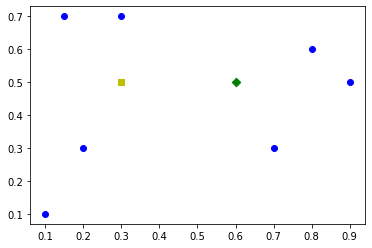

In [57]:
C_location = np.array([[0.1 ,0.1], [0.2 ,0.3],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],
              [0.9 ,0.5],[0.7 ,0.3]])
CD_location = np.array([])
CL_location = np.array([])

for i in range(len(C_D)-1):
    if i == C_D[i]:
        if i == 0:
            CD_location = np.append(CD_location,C_location[i][1])
        else:CD_location = np.vstack([CD_location,C_location[i][1]])
    else:
        if i == 0:
            CL_location = np.append(CL_location,C_location[i][1])
        else:CL_location = np.vstack([CL_location,C_location[i][1]])
print(CD_location)
print('------')
print(CL_location)




plt.scatter(C_location[:,0],C_location[:,1],color='b')
W_location = np.array([[0.6 ,0.5]])
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
L_location = np.array([[0.3 ,0.5]])
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

In [48]:
#calcolo la matrice delle distanze:
WCd_matric = np.array([])
WCd_matric = np.append(WCd_matric,W)
WCd_matric = np.vstack([WCd_matric,CD])

WL_matrix = np.array([])
WL_matrix = np.append(WL_matrix,W)
WL_matrix = np.vstack([WL_matrix,L])

buildings =['W','L0','C0','C1','C2','C3','C4','C5','C6']
store = ['Warehouse','Locker']

df_data = pd.DataFrame(data, columns=['xcord', 'ycord'], index=buildings)
df_store = pd.DataFrame(WL_matrix, columns=['xcord', 'ycord'], index=store)

dist_matrix_data = pd.DataFrame(distance_matrix(df_data.values, df_data.values), index=df_data.index, columns=df_data.index)
dist_matrix_store = pd.DataFrame(distance_matrix(df_store.values, df_store.values), index=df_store.index, columns=df_store.index)

matrix_distance_converted_in_numpy =dist_matrix_data.to_numpy()
print(dist_matrix_data)
print(dist_matrix_store)

NameError: name 'CD' is not defined

In [16]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*dist_matrix_data
LF_delivery_cost = pi_l*dist_matrix_data
Supply_cost = pi_L*dist_matrix_store
print(Supply_cost)

           Warehouse  Locker
Warehouse      0.000   0.225
Locker         0.225   0.000
